In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2

print(f"TensorFlow Version: {tf.__version__}")

C:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\rohit\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

TensorFlow Version: 2.20.0


In [3]:
# --- Configuration ---
# We point explicitly to the 'fire' folder in the root directory
DATA_PATH = './fire/' 

IMAGE_PATH = os.path.join(DATA_PATH, 'images')
MASK_PATH = os.path.join(DATA_PATH, 'masks')

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# --- Validation Check ---
if not os.path.exists(IMAGE_PATH) or not os.path.exists(MASK_PATH):
    print(f"--- ERROR ---")
    print(f"Could not find 'images' or 'masks' inside: {DATA_PATH}")
    print(f"Please ensure your folder structure is:")
    print(f"  {DATA_PATH}")
    print(f"    |-- images")
    print(f"    |-- masks")
else:
    print(f"✅ Data paths found correctly in '{DATA_PATH}'")

✅ Data paths found correctly in './fire/'


In [4]:
# REPLACE CELL 3 WITH THIS
import os
from sklearn.model_selection import train_test_split

def get_all_files_recursive(root_path):
    image_paths = []
    valid_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')
    
    # Walk through all subfolders (fire, not_fire)
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(valid_extensions):
                image_paths.append(os.path.join(root, file))
                
    return sorted(image_paths)

# 1. Get all images from subfolders (fire/not_fire)
image_files = get_all_files_recursive(IMAGE_PATH)

# 2. Get all masks (assuming they are in one folder)
# If masks are ALSO in subfolders, change this to 'get_all_files_recursive(MASK_PATH)'
mask_files = get_all_files_recursive(MASK_PATH)

print(f"Found {len(image_files)} images.")
print(f"Found {len(mask_files)} masks.")

# --- CRITICAL: Match Images to Masks ---
# Since images are in subfolders, their order might not match the masks perfectly.
# We need to filter to keep only pairs where filenames match.

img_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_files}
mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_files}

matched_images = []
matched_masks = []

for name, img_path in img_dict.items():
    if name in mask_dict:
        matched_images.append(img_path)
        matched_masks.append(mask_dict[name])

print(f"Successfully matched {len(matched_images)} pairs.")

if len(matched_images) == 0:
    print("❌ ERROR: No matching filenames found between images and masks!")
    print("Check if the file names (excluding extensions) are the same.")
else:
    # Split 80% Training, 20% Validation
    img_train, img_val, mask_train, mask_val = train_test_split(matched_images, matched_masks, test_size=0.2, random_state=42)

    print(f"Training count: {len(img_train)}")
    print(f"Validation count: {len(img_val)}")

Found 38852 images.
Found 27460 masks.
Successfully matched 27460 pairs.
Training count: 21968
Validation count: 5492


In [5]:
# REPLACE CELL 4 WITH THIS
import tensorflow as tf

# Configuration for performance
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(img_path, mask_path):
    # --- Load Image ---
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    
    # (FIX) Cast to float32 BEFORE dividing
    img = tf.cast(img, tf.float32) 
    img = img / 255.0  # Normalize to [0, 1]

    # --- Load Mask ---
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    
    # Resize using NEAREST to keep edges sharp
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    
    # (FIX) Cast to float32 BEFORE dividing
    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0 
    
    # Threshold to Binary (0 or 1)
    mask = tf.cast(mask > 0.5, dtype=tf.float32)

    return img, mask

def create_dataset(img_paths, mask_paths, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    
    # (CHANGE) Use a fixed buffer size (e.g., 1000) to save RAM
    # Old code: dataset.shuffle(buffer_size=len(img_paths))
    dataset = dataset.shuffle(buffer_size=1000) 
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# Create TF Datasets using the lists from Cell 3
train_ds = create_dataset(img_train, mask_train)
val_ds = create_dataset(img_val, mask_val)

print("✅ TensorFlow datasets created successfully.")

✅ TensorFlow datasets created successfully.


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam

def build_unet(input_shape):
    inputs = Input(input_shape)

    # --- Encoder (Going Down) ---
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck (The Bottom) ---
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # --- Decoder (Going Up) ---
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    
    # Output Layer (Sigmoid gives 0-1 probability)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and Compile
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()
print("✅ Model compiled.")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256, 256, 16)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 16)      │           2,320 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 16)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 32)      │           4,640 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128, 128, 32)      │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 32)      │           9,248 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 32)        │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 64, 64, 64)        │               0 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 64)        │          36,928 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 64)        │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               0 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 128)       │         147,584 │ dropout_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

✅ Model compiled.


In [7]:
# Cell 6: Train for just 1 Epoch to test the pipeline
print("Starting training...")
history = model.fit(train_ds, validation_data=val_ds, epochs=1) 
print("✅ Training complete.")

Starting training...
1373/1373 ━━━━━━━━━━━━━━━━━━━━ 1644s 1s/step - accuracy: 0.9877 - loss: 0.0388 - val_accuracy: 0.9920 - val_loss: 0.0200
✅ Training complete.


In [8]:
MODEL_NAME = 'fire_detection_model.h5'
model.save(MODEL_NAME)
print(f"✅ Model saved successfully as: {MODEL_NAME}")
print(f"👉 Move this file to your 'backend/analysis/' folder.")

✅ Model saved successfully as: fire_detection_model.h5
👉 Move this file to your 'backend/analysis/' folder.


Showing predictions on validation data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


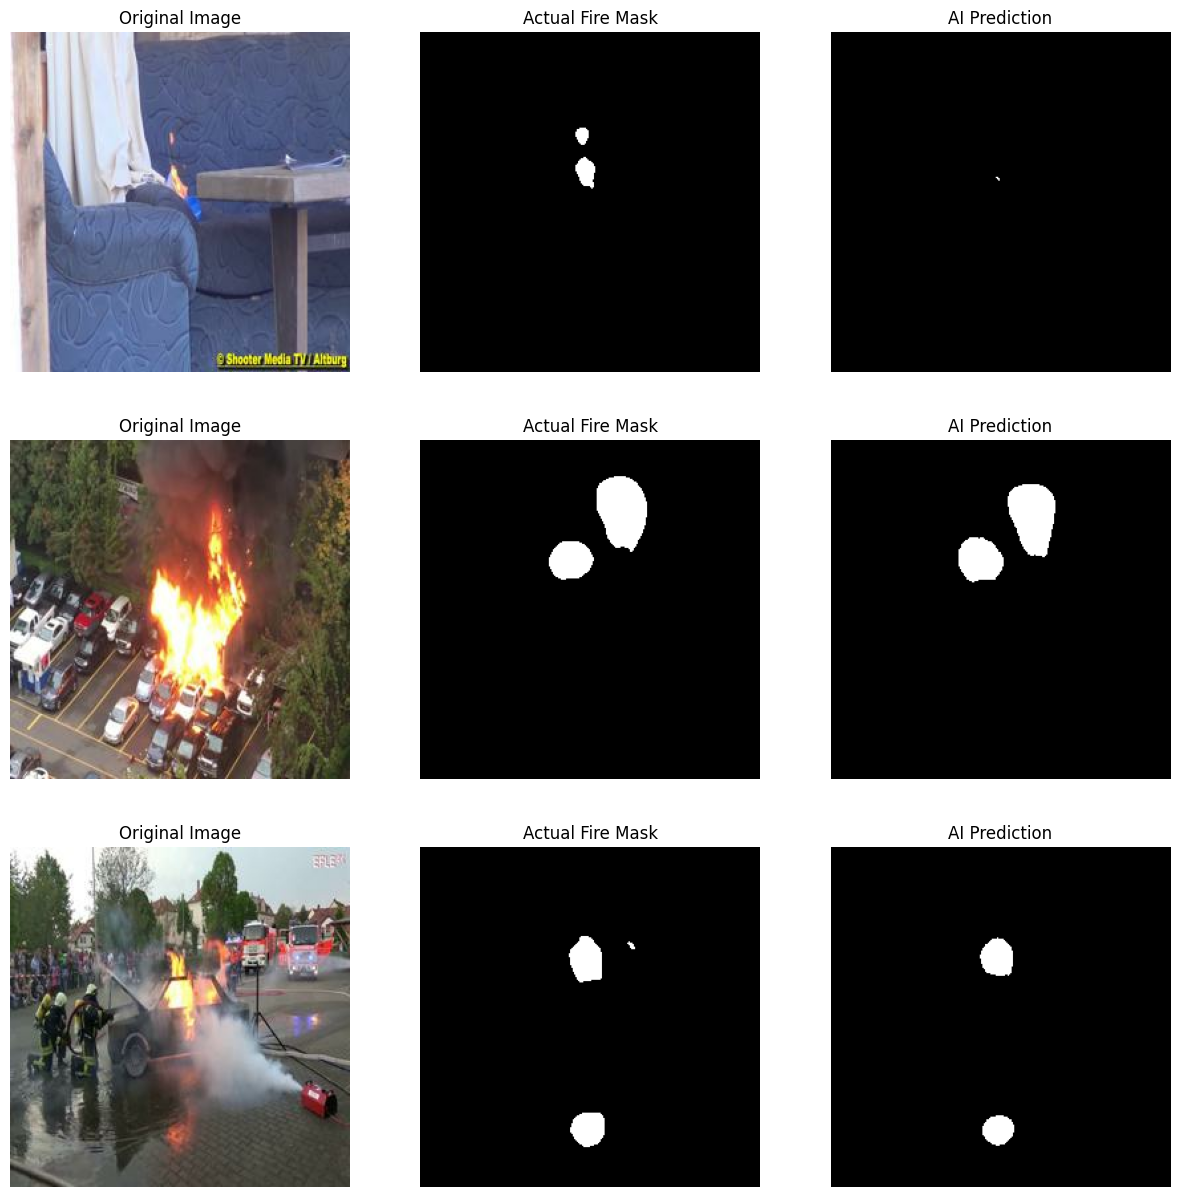

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(dataset, num=3):
    for image, true_mask in dataset.take(1):
        # Make prediction
        pred_mask = model.predict(image)
        # Threshold to binary
        pred_mask_binary = (pred_mask > 0.5).astype(np.float32)
        
        plt.figure(figsize=(15, 5 * num))
        for i in range(num):
            # Original Image
            plt.subplot(num, 3, i*3 + 1)
            plt.title("Original Image")
            plt.imshow(image[i])
            plt.axis('off')

            # True Mask (Ground Truth)
            plt.subplot(num, 3, i*3 + 2)
            plt.title("Actual Fire Mask")
            plt.imshow(true_mask[i], cmap='gray')
            plt.axis('off')

            # Predicted Mask (AI)
            plt.subplot(num, 3, i*3 + 3)
            plt.title("AI Prediction")
            plt.imshow(pred_mask_binary[i], cmap='gray')
            plt.axis('off')
        plt.show()
        break # Only show one batch

print("Showing predictions on validation data...")
show_predictions(val_ds)